In [1]:
#Importing Libraries
import os, json, cv2, numpy as np, matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F

import albumentations as A #Library for augmentations if required

In [2]:
#https://github.com/pytorch/vision/tree/main/references/detection
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

In [3]:
#Function with Augmentation for transforms before training iteration
def train_transform():
    return A.Compose([
        A.Sequential([
            #A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1), # Random change of brightness & contrast
        ], p=1)
    ],
    keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more at https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

In [4]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):               
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])

        img_original = cv2.imread(img_path)
        #img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)   #Comment for Grayscale NIR Imagesg     
        
        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = data['bboxes']
            #bboxes_original = [[900.0, 100.0, 1599.9, 1299.9]]
            keypoints_original = data['keypoints']
            
            # All subjects are glue tubes(person)
            #bboxes_labels_original = ['Glue tube' for _ in bboxes_original] 
            bboxes_labels_original = ['Person' for _ in bboxes_original]


            

        if self.transform:   
            # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints            
            # For example, if we have the following list of n keypoints for each three objects (each object has n keypoints):
            # [[obj1_kp1, obj1_kp2,.obj1_kpn], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format            
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2,...obj1_kpn, obj2_kp1, obj2_kp2,...obj2_kpn, obj3_kp1, obj3_kp2,...obj3_kpn]
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            
            # Apply augmentations
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            
            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has n keypoints):
            # [obj1_kp1, obj1_kp2,...obj1_kpn, obj2_kp1, obj2_kp2,...obj2_kpn, obj3_kp1, obj3_kp2,...obj3_kpn], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2,...obj1_kpn], [obj2_kp1, obj2_kp2,...obj2_kpn], [obj3_kp1, obj3_kp2,...obj3_kpn]]
            #keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,23,2)).tolist()
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,24,2)).tolist()          

            # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened): # Iterating over objects
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
        
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64) # all subjects are Person
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)        
        img = F.to_tensor(img)
        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all subjects are Person
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)
       
        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)

In [5]:
#KEYPOINTS_FOLDER_TRAIN = 'C:\\Users\\JHAANIK\\Extract\\glue_tubes_keypoints_dataset_134imgs\\train'
KEYPOINTS_FOLDER_TRAIN = 'C:\\Users\\JHAANIK\\Extract\\SOD\\DATA2'
dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=3, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

print("Original targets:\n", batch[3], "\n\n")
print("Transformed targets:\n", batch[1])

Original targets:
 ({'boxes': tensor([[ 951.,  293., 1399.,  852.]]), 'labels': tensor([1]), 'image_id': tensor([13]), 'area': tensor([250432.]), 'iscrowd': tensor([0]), 'keypoints': tensor([[[1.0220e+03, 7.1200e+02, 1.0000e+00],
         [1.0280e+03, 5.9400e+02, 2.0000e+00],
         [1.1220e+03, 5.8700e+02, 2.0000e+00],
         [1.1470e+03, 4.3700e+02, 2.0000e+00],
         [1.2400e+03, 8.7300e+02, 1.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.3110e+03, 5.9200e+02, 2.0000e+00],
         [9.9900e+02, 8.1600e+02, 2.0000e+00],
         [1.2700e+03, 1.0980e+03, 2.0000e+00],
         [1.4690e+03, 7.5100e+02, 2.0000e+00],
         [7.2100e+02, 1.1180e+03, 2.0000e+00],
         [1.5060e+03, 1.0890e+03, 2.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.3540e+03, 1.2470e+03, 2.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.2320e+03, 1.2750e+03, 2.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.0950e+

<generator object <genexpr> at 0x0000026118E5F5C8>


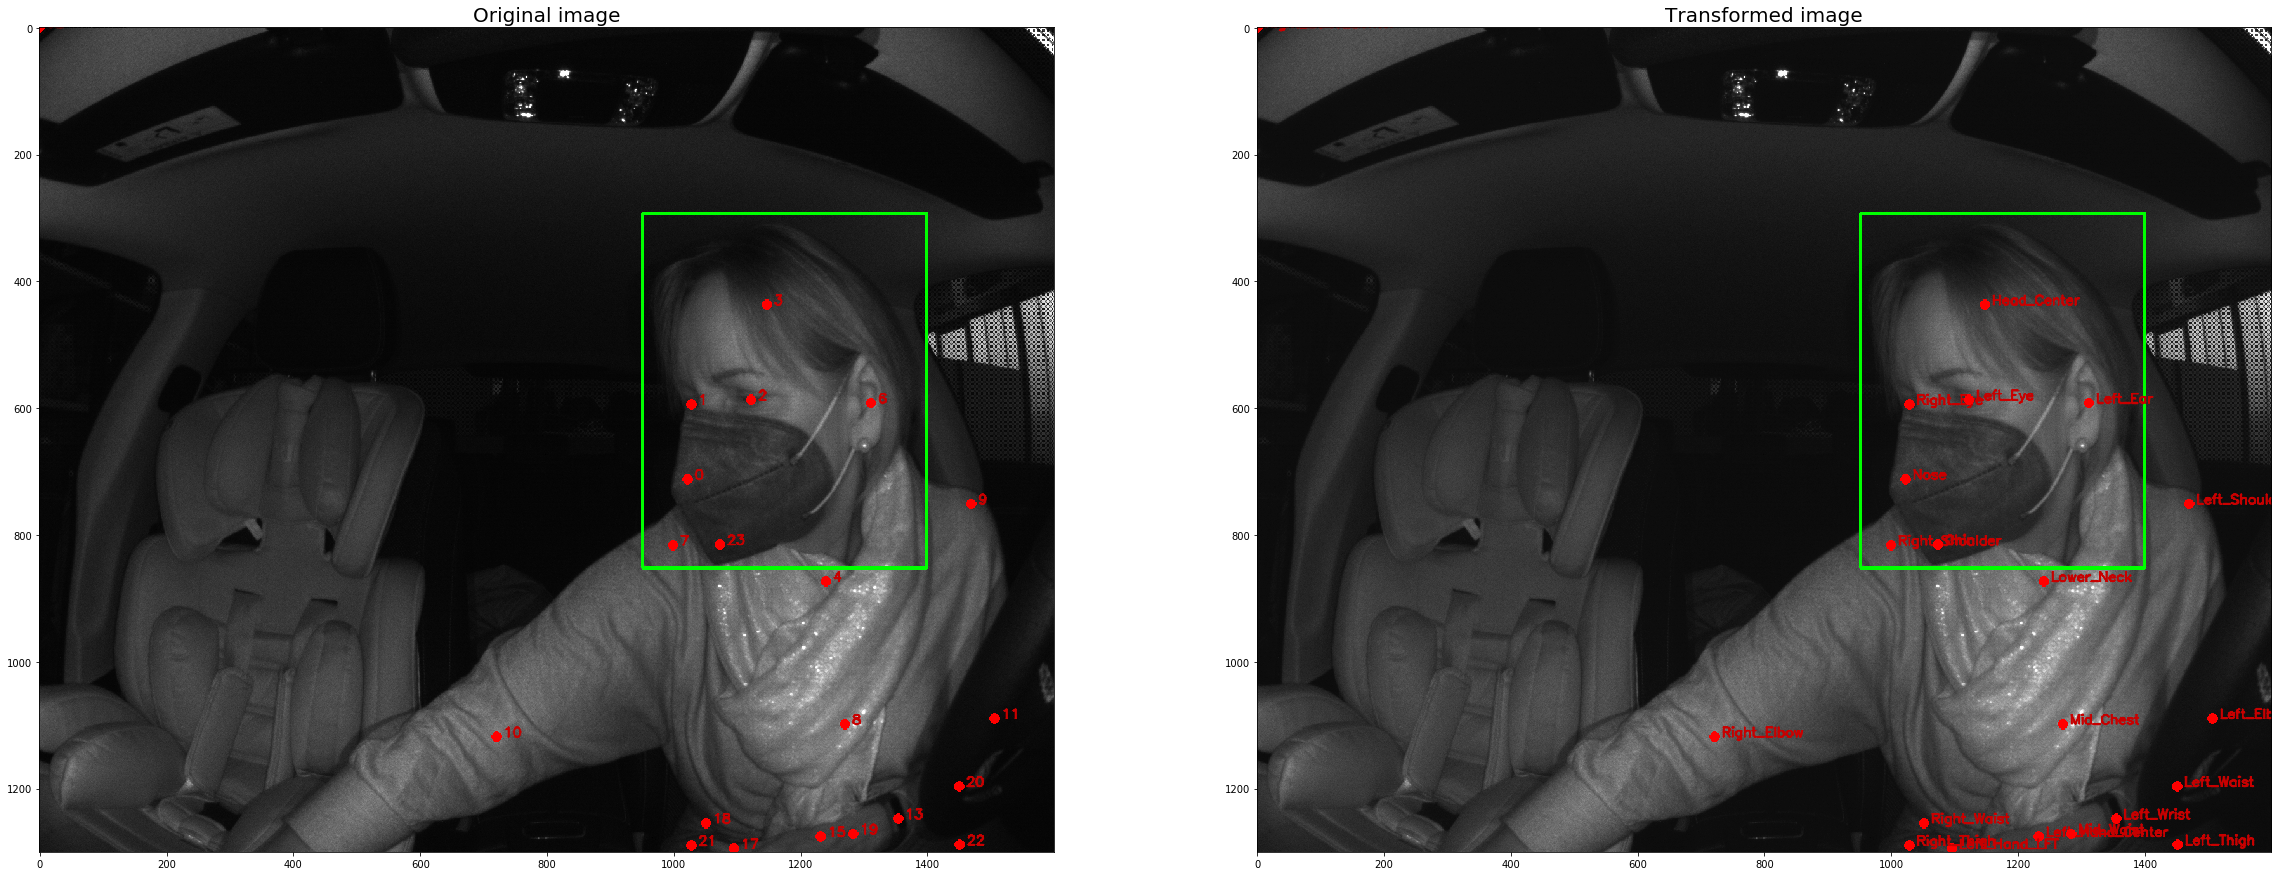

In [6]:
#"""
#For SOD 24 Keypoints Detection - [7 Facial + 17 Body] Keypoint_Class_Labels & Bounding_Box_Labels
keypoints_classes_ids2names = {0: 'Nose', 1: 'Right_Eye', 2:'Left_Eye', 3: 'Head_Center',4: 'Lower_Neck',5:  'Right_Ear',6: 'Left_Ear', 7: 'Right_Shoulder', 8: 'Mid_Chest', 9: 'Left_Shoulder', 10: 'Right_Elbow', 11: 'Left_Elbow', 12: 'Right_Wrist', 13: 'Left_Wrist', 14: 'Right_Hand_Center', 15: 'Left_Hand_Center', 16: 'Right_Hand_LFT', 17: 'Left_Hand_LFT', 18: 'Right_Waist', 19: 'Mid_Waist', 20: 'Left_Waist', 21: 'Right_Thigh', 22: 'Left_Thigh', 23:'Chin'}
#bboxes_classes_id2names = {0: 'Body', 1: 'Head', 2: 'Face'}
#"""

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 20

    for bbox in bboxes:
        #for bbox in enumerate(bboxs):
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 3)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            #print(kp)
            image = cv2.circle(image.copy(), tuple(kp), 4, (255,0,0), 8)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (200,0,0), 2, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure()
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 3)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 4, (255,0,0), 8)
                image_original = cv2.putText(image_original, " " + str(idx), tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (200,0,0), 2, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
        
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    #print(kps)
    print(kp[2] for kp in kps)
    if(kp[2]==2 for kp in kps):
        keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

In [7]:
def get_model(num_keypoints, weights_path=None):
    
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

In [8]:
def get_model_trained(num_keypoints, weights_path):
    
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict['model_state_dict'])
        optimizer.load_state_dict(state_dict['optimizer_state_dict'])        
        
    return model

In [9]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

KEYPOINTS_FOLDER_TRAIN = 'C:\\Users\\JHAANIK\\Extract\\SOD_24\\DATA2'

KEYPOINTS_FOLDER_TEST = 'C:\\Users\\JHAANIK\\Extract\\SOD_24\\TEST2'

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=2, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [11]:
#model = get_model(num_keypoints = 24)
model = get_model_trained(num_keypoints=24, weights_path='keypoint_final.pth')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
num_epochs = 15

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1000)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)
    
# Save model weights after training
torch.save({'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()},
            'keypoint_final_epochs-15.pth')

Epoch: [0]  [   0/1945]  eta: 2:27:40  lr: 0.000002  loss: 2.6852 (2.6852)  loss_classifier: 0.0155 (0.0155)  loss_box_reg: 0.0277 (0.0277)  loss_keypoint: 2.6390 (2.6390)  loss_objectness: 0.0013 (0.0013)  loss_rpn_box_reg: 0.0017 (0.0017)  time: 4.5555  data: 0.1490  max mem: 1891


In [26]:
# import the transforms module
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
IMAGE_FOLDER_INFERENCE = 'C:\\Users\\JHAANIK\\EXTRACT\\SOD_24\\TEST1'
dataset = ClassDataset(IMAGE_FOLDER_INFERENCE, transform=None, demo=False)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [27]:
iterator = iter(data_loader)
images, targets = next(iterator)
#print(images)
images = list(image.to(device) for image in images)

In [36]:

model_hbbox = get_model_trained(num_keypoints=24, weights_path='Model_Weights/head_bbox_epochs-50_batch-2.pth')
model_kp = get_model_trained(num_keypoints=24, weights_path='Model_Weights/keypoint_final.pth')
#model_kp = get_model_trained(num_keypoints=24, weights_path='Model_Weights/kp_batch-2_epochs-10_pretrain_epochs-8.pth')
"""
iterator = iter(data_loader_test)
images, targets = next(iterator)
images = list(image.to(device) for image in images)
"""

with torch.no_grad():
    model_hbbox.to(device)
    model_hbbox.eval()
    output_hbbox = model_hbbox(images)

with torch.no_grad():
    model_kp.to(device)
    model_kp.eval()
    output_kp = model_kp(images)

print("Predictions: \n", output_hbbox)
print("Predictions: \n", output_kp)

Predictions: 
 [{'boxes': tensor([[1141.5817,  194.6114, 1380.3269,  516.9795]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0'), 'keypoints': tensor([[[1.3324e+03, 3.9143e+02, 1.0000e+00],
         [1.2772e+03, 3.3960e+02, 1.0000e+00],
         [1.3454e+03, 3.6066e+02, 1.0000e+00],
         [1.2739e+03, 2.7480e+02, 1.0000e+00],
         [1.2902e+03, 5.1617e+02, 1.0000e+00],
         [1.1765e+03, 3.7847e+02, 1.0000e+00],
         [1.3340e+03, 3.8495e+02, 1.0000e+00],
         [1.1424e+03, 5.1617e+02, 1.0000e+00],
         [1.1424e+03, 5.1617e+02, 1.0000e+00],
         [1.3681e+03, 5.1617e+02, 1.0000e+00],
         [1.3340e+03, 3.7361e+02, 1.0000e+00],
         [1.3422e+03, 3.8495e+02, 1.0000e+00],
         [1.2398e+03, 4.0763e+02, 1.0000e+00],
         [1.3243e+03, 3.5094e+02, 1.0000e+00],
         [1.1424e+03, 4.0277e+02, 1.0000e+00],
         [1.3795e+03, 4.5299e+02, 1.0000e+00],
         [1.2658e+03, 3.8495e+02, 1.0000e+00],
    

In [37]:
image = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output_hbbox[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.85)[0].tolist() # Indexes of boxes with scores > 0.85
post_nms_idxs = torchvision.ops.nms(output_hbbox[0]['boxes'][high_scores_idxs], output_hbbox[0]['scores'][high_scores_idxs], 0.7).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.7)

#print(output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy())
# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

#print(kps)

bboxes = []
for bbox in output_hbbox[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))

print(bboxes)
print(scores)

[[1141, 194, 1380, 516]]
[0.9998259]


In [42]:

#"""
#For SOD 24 Keypoints Detection - [7 Facial + 17 Body] Keypoint_Class_Labels & Bounding_Box_Labels
keypoints_classes_ids2names = {0: 'Nose', 1: 'Right_Eye', 2:'Left_Eye', 3: 'Head_Center',4: 'Lower_Neck',5:  'Right_Ear',6: 'Left_Ear', 7: 'Right_Shoulder', 8: 'Mid_Chest', 9: 'Left_Shoulder', 10: 'Right_Elbow', 11: 'Left_Elbow', 12: 'Right_Wrist', 13: 'Left_Wrist', 14: 'Right_Hand_Center', 15: 'Left_Hand_Center', 16: 'Right_Hand_LFT', 17: 'Left_Hand_LFT', 18: 'Right_Waist', 19: 'Mid_Waist', 20: 'Left_Waist', 21: 'Right_Thigh', 22: 'Left_Thigh', 23:'Chin'}
#bboxes_classes_id2names = {0: 'Body', 1: 'Head', 2: 'Face'}
#"""

def visualize_final(image, bboxes, keypoints, keypoints_scores, parameter):
    img=image.copy()
    fontsize=20
    for bbox in bboxes:
        #for bbox in enumerate(bboxs):
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 3)
    
    fidx=0
    idx=0
    for kps in keypoints:
        for idx, kp in enumerate(kps):
        #print(kp)
            x=keypoints_scores[fidx][idx]
            #print(tuple(kp))
            if(x>=parameter):
                #print(tuple(kp))
                image_relevant = cv2.circle(image, tuple(kp), 4, (255,0,0), 8)
                #image_relevant = cv2.putText(image, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (200,0,0), 2, cv2.LINE_AA)
                image_relevant = cv2.putText(image, " " + str(idx), tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (200,0,0), 2, cv2.LINE_AA)
        fidx=fidx+1   

    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(img, tuple(kp), 4, (255,0,0), 8)
            image = cv2.putText(img, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (200,0,0), 2, cv2.LINE_AA)
        


    f, ax = plt.subplots(1, 2, figsize=(40, 20))

    ax[0].imshow(image)
    ax[0].set_title('Original image with all keypoints', fontsize=fontsize)

    ax[1].imshow(image_relevant)
    ax[1].set_title('Original image with only high accuracy keypoints', fontsize=fontsize)

[[[1331, 387], [1277, 348], [1342, 366], [1263, 268], [1272, 622], [1186, 406], [1355, 431], [1053, 593], [1272, 822], [1417, 605], [1084, 804], [1505, 855], [1425, 748], [1519, 684], [1552, 631], [1570, 618], [1401, 605], [1241, 447], [1058, 983], [1310, 1123], [1428, 1069], [1287, 1290], [1565, 1238], [1331, 501]]]
 


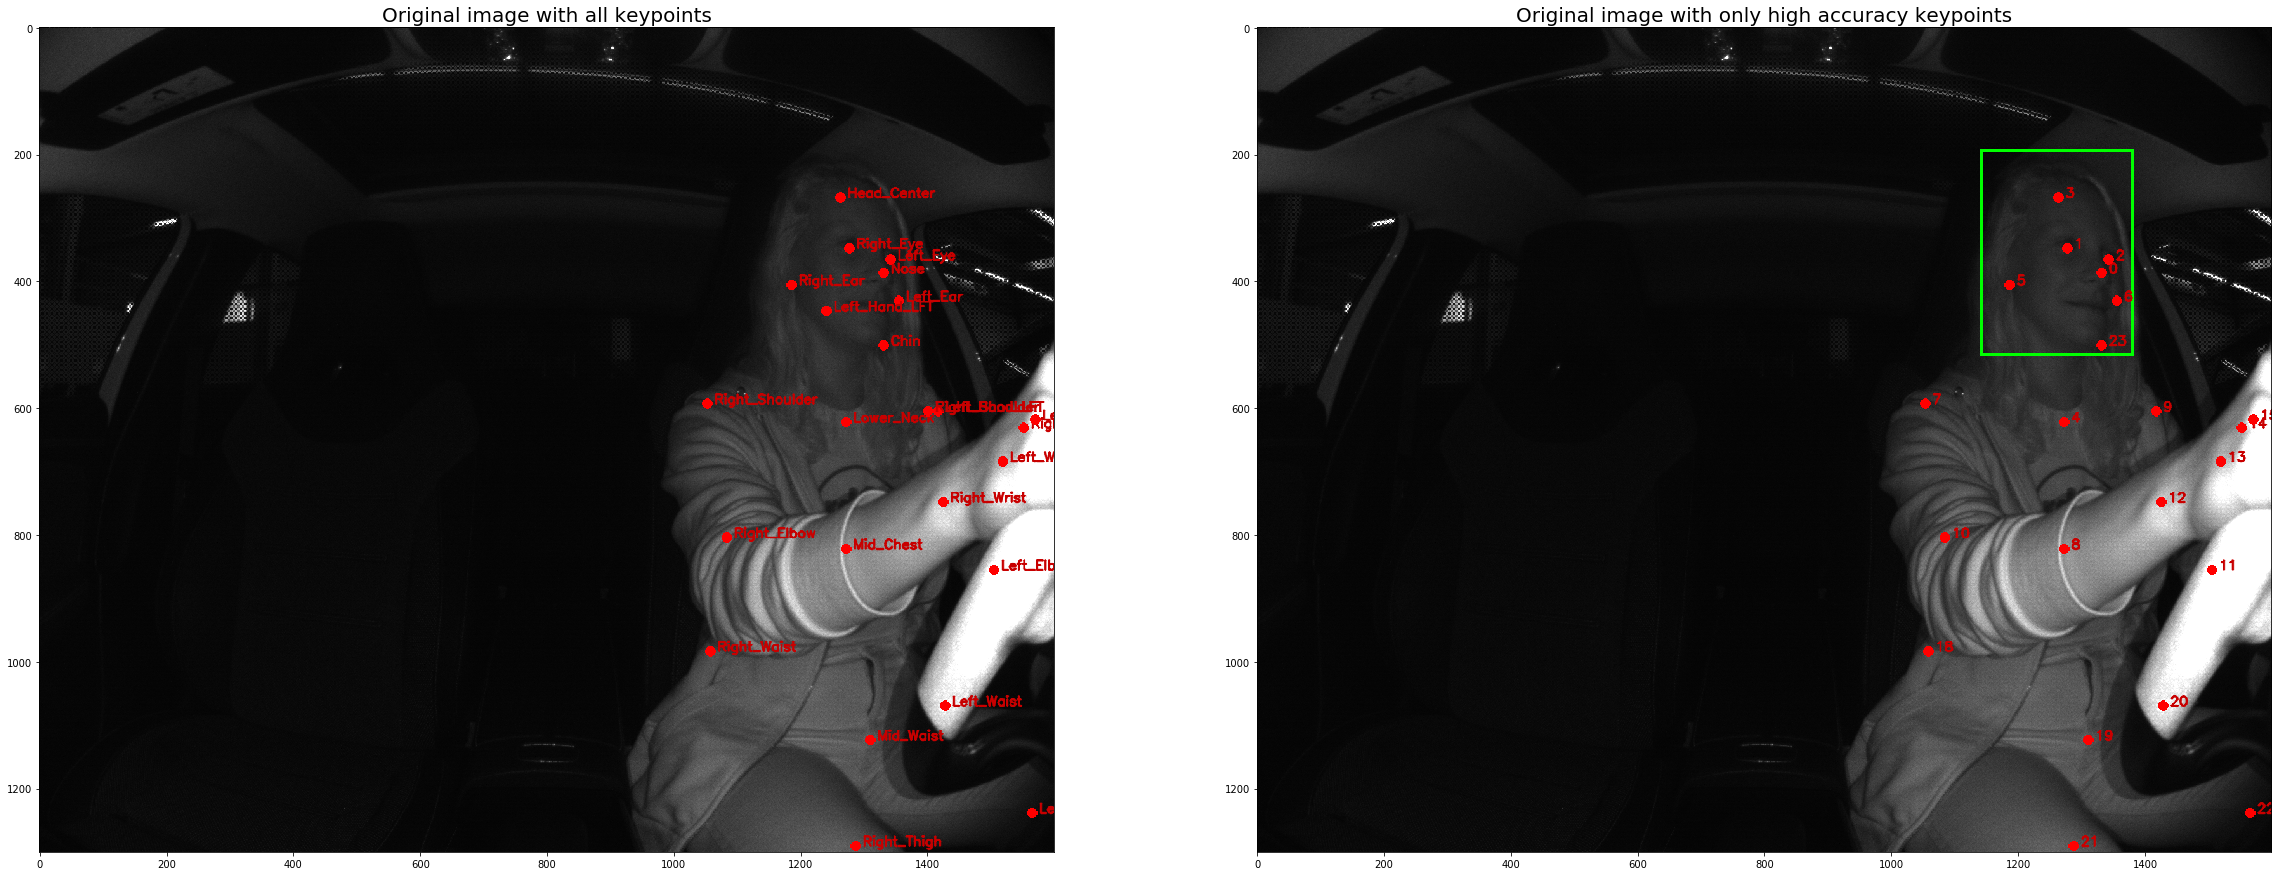

In [43]:
image = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output_kp[0]['scores'].detach().cpu().numpy()


high_scores_idxs = np.where(scores > 0.85)[0].tolist() # Indexes of boxes with scores > 0.85
post_nms_idxs = torchvision.ops.nms(output_kp[0]['boxes'][high_scores_idxs], output_kp[0]['scores'][high_scores_idxs], 0.7).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.7)

#print(output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy())
# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output_kp[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
        keypoints.append([list(map(int, kp[:2] )) for kp in kps])
keypoints_scores=output_kp[0]['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()
print(keypoints)
print(" ")
parameter=np.mean(np.mean(keypoints_scores))/4


    
visualize_final(image, bboxes, keypoints, keypoints_scores, parameter)